# CS608 Assignment 1 Model Training

### Preparations

In [36]:
# Importing necessary libraries

import cornac
from cornac.data import Reader
from cornac.data import Dataset
from cornac.models import MF, PMF, BPR, WMF, MMMF, EASE
from cornac.eval_methods import BaseMethod, RatioSplit
from cornac.metrics import MAE, RMSE, AUC, FMeasure, MAP, NCRR, NDCG, Recall
from cornac.hyperopt import RandomSearch
from cornac.hyperopt import Discrete, Continuous
from cornac.experiment import Experiment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import hmean

SEED = 666
VERBOSE = True

In [37]:
# Loading the training dataset
train_data = Reader().read(fpath='cs608_ip_train_v3.csv', fmt='UIR', sep=',', skip_lines=1, id_inline=False, parser=None)

# Loading the test dataset
test_data = Reader().read(fpath='cs608_ip_probe_v3.csv', fmt='UIR', sep=',', skip_lines=1, id_inline=False, parser=None)


### Data Analysis

In [38]:
df_train = pd.DataFrame(train_data, columns=["user_id", "item_id", "rating"])
df_train.head()

,user_id,item_id,rating
0,11239,1,5.0
1,11239,2,4.0
2,11239,3,5.0
3,11239,4,5.0
4,11239,5,5.0


In [39]:
n_users = df_train.user_id.nunique()
n_items = df_train.item_id.nunique()
n_ratings = len(df_train)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 11525
Number of items: 28771
Number of available ratings: 112104
Number of all possible ratings: 331585775
----------------------------------------
SPARSITY: 99.97%


<Axes: xlabel='rating'>

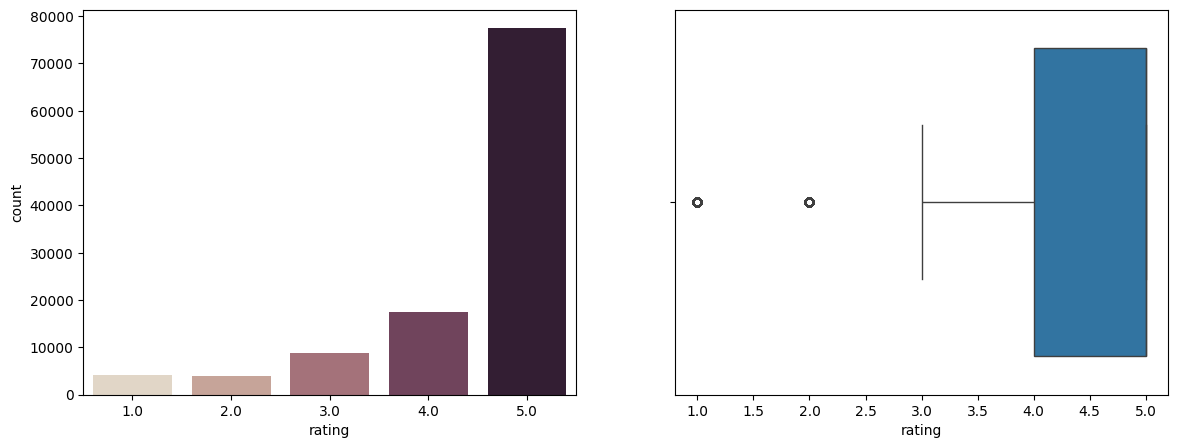

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="rating", hue="rating", data=df_train, palette="ch:.25", ax=axes[0], legend=False)
sns.boxplot(x="rating", data=df_train, ax=axes[1])

Top 10 items with the most ratings:
item_id
431     331
168     319
22      271
164     264
21      255
597     187
1053    185
228     173
178     161
852     153


[Text(0.5, 1.0, 'log-log plot'),
 Text(0.5, 0, '#ratings (log scale)'),
 Text(0, 0.5, '#items (log scale)')]

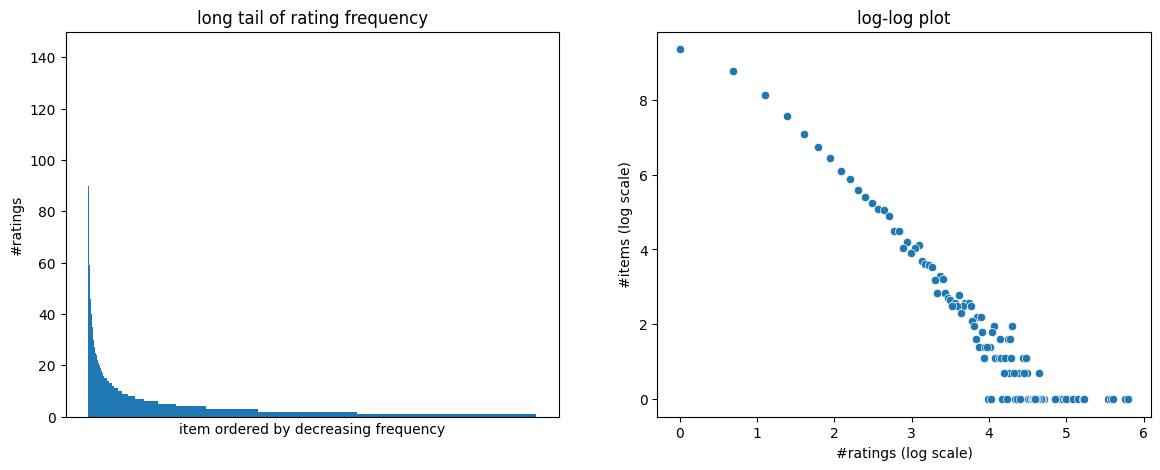

In [41]:
item_rate_count = df_train.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)
print("Top 10 items with the most ratings:")
print(item_rate_count.head(10).to_string())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=item_rate_count.index, height=item_rate_count.values, width=1.0, align="edge")
axes[0].set_ylim(0, 150)
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency",
            xlabel="item ordered by decreasing frequency",
            ylabel="#ratings")

count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)")


### Matrix Factorization Model Training

Important understanding for simple MF:
- Larger latent vectors (k) tends to show better ranking performance
- More iterations improve RMSE (exact prediction) but worsen ranking stats (overfitting?) best seen around 10 iterations
- Learning rate of around 0.01 seems to perform best
- Bias improves RMSE but worsens ranking

-> Best result with MF(k=300, max_iter=10, learning_rate=0.01, lambda_reg=0.01, use_bias=False)



In [ ]:
mf_1 = MF(k=150, max_iter=10, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
        verbose=VERBOSE, name=f"MF_k_150")

mf_2 = MF(k=200, max_iter=10, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
        verbose=VERBOSE, name=f"MF_k_200")

mf_3 = MF(k=250, max_iter=10, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
        verbose=VERBOSE, name=f"MF_k_250")

mf_4 = MF(k=300, max_iter=10, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
        verbose=VERBOSE, name=f"MF_k_300")

models = [mf_1, mf_2, mf_3, mf_4]

In [121]:
# Defining the evaluation method
eval_method = BaseMethod.from_splits(
    train_data=train_data, test_data=test_data, val_data=None, 
    fmt='UIR', rating_threshold=2.5, 
    random_state=SEED, verbose=VERBOSE
)

# Defining the evaluation metrics
metrics = [
    RMSE(),
    AUC(),
    FMeasure(k=50),
    NDCG(k=50),
    NCRR(k=50),
    Recall(k=50)
]

# Running the experiment
Experiment(eval_method=eval_method, models=models, metrics=metrics, verbose=VERBOSE).run()



rating_threshold = 2.5
exclude_unknowns = False
---
Training data:
Number of users = 11525
Number of items = 28771
Number of ratings = 112104
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 11525
Number of items = 28771
Number of ratings = 52381
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 11525
Total items = 28771

[MF_k_150] Training started!


100%|██████████| 10/10 [00:00<00:00, 174.93it/s, loss=785316.62]


Optimization finished!

[MF_k_150] Evaluation started!


Ranking: 100%|██████████| 11515/11515 [00:12<00:00, 925.23it/s]



[MF_k_200] Training started!


100%|██████████| 10/10 [00:00<00:00, 129.59it/s, loss=755211.00]


Optimization finished!

[MF_k_200] Evaluation started!


Ranking: 100%|██████████| 11515/11515 [00:12<00:00, 889.00it/s]



[MF_k_250] Training started!


100%|██████████| 10/10 [00:00<00:00, 89.61it/s, loss=743648.06] 


Optimization finished!

[MF_k_250] Evaluation started!


Ranking: 100%|██████████| 11515/11515 [00:19<00:00, 601.94it/s]



[MF_k_300] Training started!


100%|██████████| 10/10 [00:00<00:00, 78.13it/s, loss=712621.56]


Optimization finished!

[MF_k_300] Evaluation started!


Ranking: 100%|██████████| 11515/11515 [00:17<00:00, 669.05it/s]


TEST:
...
         |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
-------- + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
MF_k_150 | 3.2394 | 0.7679 | 0.0103 |  0.0322 |  0.0420 |    0.0683 |    0.1191 |  12.9666
MF_k_200 | 3.2143 | 0.7691 | 0.0104 |  0.0330 |  0.0428 |    0.0695 |    0.1629 |  13.4991
MF_k_250 | 3.2175 | 0.7698 | 0.0107 |  0.0352 |  0.0448 |    0.0715 |    0.2258 |  19.6523
MF_k_300 | 3.1779 | 0.7703 | 0.0105 |  0.0359 |  0.0451 |    0.0708 |    0.2562 |  17.7329



Hyperparameter Tuning using RandomSearch

In [ ]:
# base model
mf = MF(k=150, max_iter=10, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
        verbose=VERBOSE, name=f"MF")

# Split the dataset into train and val sets
train_set, val_set = train_test_split(
    train_data, test_size=0.2, random_state=SEED
)

# evaluation method
eval_method = BaseMethod.from_splits(
    train_data=train_set, test_data=test_data, val_data=val_set, 
    fmt='UIR', rating_threshold=2.5, exclude_unknowns=True,
    random_state=SEED, verbose=VERBOSE
)

# Random Search
rs_mf = RandomSearch(
    model=mf,
    space=[
        Discrete(name="k", values=[i for i in range(200, 400, 50)]),
        Discrete(name="max_iter", values=[i for i in range(5, 15, 1)]),
        Continuous(name="learning_rate", low=0.01, high=0.1),
        Continuous(name="lambda_reg", low=0.01, high=0.1)
    ],
    metric=AUC(),
    eval_method=eval_method,
    n_trails=20,
)

# Running the experiment
Experiment(eval_method=eval_method, models=[mf, rs_mf], metrics=metrics, verbose=True).run()


rating_threshold = 2.5
exclude_unknowns = True
---
Training data:
Number of users = 11525
Number of items = 27573
Number of ratings = 100893
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 11525
Number of items = 27573
Number of ratings = 51668
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 11525
Number of items = 27573
Number of ratings = 9941
---
Total users = 11525
Total items = 27573

[MF] Training started!


100%|██████████| 10/10 [00:00<00:00, 138.54it/s, loss=818561.94]


Optimization finished!

[MF] Evaluation started!


Ranking: 100%|██████████| 6248/6248 [00:05<00:00, 1130.38it/s]



[RandomSearch_MF] Training started!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.053619368003598594, 'learning_rate': 0.06644994821167129, 'max_iter': np.int64(5)}


100%|██████████| 5/5 [00:00<00:00, 57.35it/s, loss=43655.20]  


Optimization finished!
Evaluating: {'k': np.int64(300), 'lambda_reg': 0.05770008012171255, 'learning_rate': 0.09410375642348798, 'max_iter': np.int64(9)}


100%|██████████| 9/9 [00:00<00:00, 55.86it/s, loss=1264.44]   


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.013689488355816752, 'learning_rate': 0.01670933856831664, 'max_iter': np.int64(7)}


100%|██████████| 7/7 [00:00<00:00, 65.36it/s, loss=660848.00] 


Optimization finished!
Evaluating: {'k': np.int64(300), 'lambda_reg': 0.04830972563852177, 'learning_rate': 0.08165354485208216, 'max_iter': np.int64(13)}


100%|██████████| 13/13 [00:00<00:00, 67.65it/s, loss=633.16]   


Optimization finished!
Evaluating: {'k': np.int64(300), 'lambda_reg': 0.06700487720112798, 'learning_rate': 0.06531026767574108, 'max_iter': np.int64(11)}


100%|██████████| 11/11 [00:00<00:00, 55.73it/s, loss=1822.88]  


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.05331695093974359, 'learning_rate': 0.031461647470050036, 'max_iter': np.int64(9)}


100%|██████████| 9/9 [00:00<00:00, 80.35it/s, loss=49219.42]  


Optimization finished!
Evaluating: {'k': np.int64(300), 'lambda_reg': 0.03819892435406086, 'learning_rate': 0.039910433538563654, 'max_iter': np.int64(14)}


100%|██████████| 14/14 [00:00<00:00, 67.85it/s, loss=2005.31]  


Optimization finished!
Evaluating: {'k': np.int64(300), 'lambda_reg': 0.09483066715565042, 'learning_rate': 0.03816201519065788, 'max_iter': np.int64(14)}


100%|██████████| 14/14 [00:00<00:00, 67.80it/s, loss=4738.68]  


Optimization finished!
Evaluating: {'k': np.int64(350), 'lambda_reg': 0.013362850633004608, 'learning_rate': 0.042638036486596816, 'max_iter': np.int64(10)}


100%|██████████| 10/10 [00:00<00:00, 53.44it/s, loss=5527.76]  


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.07253964504534212, 'learning_rate': 0.04425179503322282, 'max_iter': np.int64(10)}


100%|██████████| 10/10 [00:00<00:00, 73.98it/s, loss=9180.85]  


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.036868613377158625, 'learning_rate': 0.06504638692307996, 'max_iter': np.int64(6)}


100%|██████████| 6/6 [00:00<00:00, 79.41it/s, loss=19070.85]  

Optimization finished!


Evaluating: {'k': np.int64(350), 'lambda_reg': 0.03753001372121043, 'learning_rate': 0.032183590038983904, 'max_iter': np.int64(12)}


100%|██████████| 12/12 [00:00<00:00, 53.67it/s, loss=9033.34]  


Optimization finished!
Evaluating: {'k': np.int64(300), 'lambda_reg': 0.03558417352945166, 'learning_rate': 0.09278880691860955, 'max_iter': np.int64(13)}


100%|██████████| 13/13 [00:00<00:00, 66.48it/s, loss=357.49]   


Optimization finished!
Evaluating: {'k': np.int64(200), 'lambda_reg': 0.0862112410333259, 'learning_rate': 0.024802470043872284, 'max_iter': np.int64(12)}


100%|██████████| 12/12 [00:00<00:00, 115.44it/s, loss=41096.96] 

Optimization finished!


Evaluating: {'k': np.int64(350), 'lambda_reg': 0.03523501308090438, 'learning_rate': 0.05976973714901828, 'max_iter': np.int64(10)}


100%|██████████| 10/10 [00:00<00:00, 38.18it/s, loss=1652.92]  


Optimization finished!
Evaluating: {'k': np.int64(300), 'lambda_reg': 0.0983632742443069, 'learning_rate': 0.057979189978096764, 'max_iter': np.int64(12)}


100%|██████████| 12/12 [00:00<00:00, 66.20it/s, loss=3218.76]  


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.0626807938294935, 'learning_rate': 0.05000698202653785, 'max_iter': np.int64(6)}


100%|██████████| 6/6 [00:00<00:00, 78.58it/s, loss=53193.54]  

Optimization finished!


Evaluating: {'k': np.int64(200), 'lambda_reg': 0.0890715020386181, 'learning_rate': 0.046952664081607594, 'max_iter': np.int64(5)}


100%|██████████| 5/5 [00:00<00:00, 107.99it/s, loss=153119.72]

Optimization finished!


Evaluating: {'k': np.int64(200), 'lambda_reg': 0.09582131756749274, 'learning_rate': 0.06542902096452982, 'max_iter': np.int64(10)}


100%|██████████| 10/10 [00:00<00:00, 114.98it/s, loss=4565.01] 

Optimization finished!


Evaluating: {'k': np.int64(200), 'lambda_reg': 0.05917602526226908, 'learning_rate': 0.08125620381797308, 'max_iter': np.int64(13)}


100%|██████████| 13/13 [00:00<00:00, 117.37it/s, loss=991.66]  

Optimization finished!


Evaluating: {'k': np.int64(300), 'lambda_reg': 0.09148257483445263, 'learning_rate': 0.02539197625331408, 'max_iter': np.int64(8)}


100%|██████████| 8/8 [00:00<00:00, 56.36it/s, loss=173939.05] 


Optimization finished!
Evaluating: {'k': np.int64(300), 'lambda_reg': 0.038779007013621976, 'learning_rate': 0.07621521264161424, 'max_iter': np.int64(10)}


100%|██████████| 10/10 [00:00<00:00, 65.63it/s, loss=972.82]   


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.014434362324745239, 'learning_rate': 0.012609039794063621, 'max_iter': np.int64(5)}


100%|██████████| 5/5 [00:00<00:00, 77.44it/s, loss=1010197.69]

Optimization finished!


Evaluating: {'k': np.int64(200), 'lambda_reg': 0.04602466533524824, 'learning_rate': 0.05782100365376523, 'max_iter': np.int64(6)}


100%|██████████| 6/6 [00:00<00:00, 110.38it/s, loss=33572.30] 

Optimization finished!


Evaluating: {'k': np.int64(350), 'lambda_reg': 0.07208156302915437, 'learning_rate': 0.0927947571783685, 'max_iter': np.int64(12)}


100%|██████████| 12/12 [00:00<00:00, 52.70it/s, loss=1169.69]  


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.03425155182998964, 'learning_rate': 0.08193545059364646, 'max_iter': np.int64(6)}


100%|██████████| 6/6 [00:00<00:00, 77.05it/s, loss=8124.97]   

Optimization finished!


Evaluating: {'k': np.int64(200), 'lambda_reg': 0.0710001627504048, 'learning_rate': 0.017950158406871995, 'max_iter': np.int64(14)}


100%|██████████| 14/14 [00:00<00:00, 116.84it/s, loss=71341.20] 


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.03333849551832386, 'learning_rate': 0.03973792346010791, 'max_iter': np.int64(11)}


100%|██████████| 11/11 [00:00<00:00, 79.63it/s, loss=6748.62]  


Optimization finished!
Evaluating: {'k': np.int64(350), 'lambda_reg': 0.08228334758418446, 'learning_rate': 0.09259212775725134, 'max_iter': np.int64(11)}


100%|██████████| 11/11 [00:00<00:00, 52.61it/s, loss=1563.30]  


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.07645869346960298, 'learning_rate': 0.023691253549274253, 'max_iter': np.int64(7)}


100%|██████████| 7/7 [00:00<00:00, 78.02it/s, loss=337976.62] 

Optimization finished!


Evaluating: {'k': np.int64(200), 'lambda_reg': 0.03617415935421811, 'learning_rate': 0.03985335222644612, 'max_iter': np.int64(5)}


100%|██████████| 5/5 [00:00<00:00, 105.41it/s, loss=235659.59]

Optimization finished!


Evaluating: {'k': np.int64(250), 'lambda_reg': 0.09077416369993231, 'learning_rate': 0.08690694543834906, 'max_iter': np.int64(6)}


100%|██████████| 6/6 [00:00<00:00, 78.06it/s, loss=10018.67]  

Optimization finished!


Evaluating: {'k': np.int64(200), 'lambda_reg': 0.0812035728193364, 'learning_rate': 0.0442154441683297, 'max_iter': np.int64(11)}


100%|██████████| 11/11 [00:00<00:00, 113.63it/s, loss=7630.53] 

Optimization finished!


Evaluating: {'k': np.int64(250), 'lambda_reg': 0.04086852559334279, 'learning_rate': 0.06636495934467744, 'max_iter': np.int64(8)}


100%|██████████| 8/8 [00:00<00:00, 78.02it/s, loss=4497.11]   


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.04942045283438519, 'learning_rate': 0.09360633256475291, 'max_iter': np.int64(13)}


100%|██████████| 13/13 [00:00<00:00, 82.00it/s, loss=618.71]   


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.029154499989065184, 'learning_rate': 0.09676056228277784, 'max_iter': np.int64(10)}


100%|██████████| 10/10 [00:00<00:00, 61.84it/s, loss=524.94]   


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.05615436453759294, 'learning_rate': 0.039469616237731237, 'max_iter': np.int64(11)}


100%|██████████| 11/11 [00:00<00:00, 58.44it/s, loss=8175.92]  


Optimization finished!
Evaluating: {'k': np.int64(300), 'lambda_reg': 0.08616943678934466, 'learning_rate': 0.09059670621167806, 'max_iter': np.int64(9)}


100%|██████████| 9/9 [00:00<00:00, 53.03it/s, loss=2320.88]   


Optimization finished!
Evaluating: {'k': np.int64(200), 'lambda_reg': 0.01821290539801765, 'learning_rate': 0.05108308410820704, 'max_iter': np.int64(6)}


100%|██████████| 6/6 [00:00<00:00, 87.34it/s, loss=48533.36]  

Optimization finished!


Evaluating: {'k': np.int64(200), 'lambda_reg': 0.010571718656690491, 'learning_rate': 0.01867446874410944, 'max_iter': np.int64(6)}


100%|██████████| 6/6 [00:00<00:00, 84.43it/s, loss=748062.69] 

Optimization finished!


Evaluating: {'k': np.int64(200), 'lambda_reg': 0.01782525884146039, 'learning_rate': 0.0634390421292986, 'max_iter': np.int64(6)}


100%|██████████| 6/6 [00:00<00:00, 57.16it/s, loss=22145.90]  

Optimization finished!


Evaluating: {'k': np.int64(300), 'lambda_reg': 0.052676852336397746, 'learning_rate': 0.07710832592405326, 'max_iter': np.int64(6)}


100%|██████████| 6/6 [00:00<00:00, 55.10it/s, loss=9925.74]   


Optimization finished!
Evaluating: {'k': np.int64(200), 'lambda_reg': 0.046317443407969304, 'learning_rate': 0.02335150536481952, 'max_iter': np.int64(8)}


100%|██████████| 8/8 [00:00<00:00, 91.57it/s, loss=230422.45] 

Optimization finished!


Evaluating: {'k': np.int64(250), 'lambda_reg': 0.0480993339532278, 'learning_rate': 0.0706374693004175, 'max_iter': np.int64(6)}


100%|██████████| 6/6 [00:00<00:00, 65.16it/s, loss=15013.00]  

Optimization finished!


Evaluating: {'k': np.int64(350), 'lambda_reg': 0.0702331771726878, 'learning_rate': 0.09447837005835441, 'max_iter': np.int64(13)}


100%|██████████| 13/13 [00:00<00:00, 46.42it/s, loss=1051.63]  


Optimization finished!
Evaluating: {'k': np.int64(350), 'lambda_reg': 0.0724820744404273, 'learning_rate': 0.030163168116728978, 'max_iter': np.int64(5)}


100%|██████████| 5/5 [00:00<00:00, 43.13it/s, loss=458630.06] 


Optimization finished!
Evaluating: {'k': np.int64(200), 'lambda_reg': 0.09417008892738152, 'learning_rate': 0.011605666655837238, 'max_iter': np.int64(12)}


100%|██████████| 12/12 [00:00<00:00, 80.17it/s, loss=475225.25]


Optimization finished!
Evaluating: {'k': np.int64(300), 'lambda_reg': 0.05462303692043669, 'learning_rate': 0.03958225640875825, 'max_iter': np.int64(8)}


100%|██████████| 8/8 [00:00<00:00, 59.18it/s, loss=31680.25]  


Optimization finished!
Evaluating: {'k': np.int64(250), 'lambda_reg': 0.03611879098669281, 'learning_rate': 0.0929010667749868, 'max_iter': np.int64(8)}


100%|██████████| 8/8 [00:00<00:00, 66.38it/s, loss=1484.79]   


Optimization finished!
Evaluating: {'k': np.int64(200), 'lambda_reg': 0.07668829983880737, 'learning_rate': 0.09991117616084684, 'max_iter': np.int64(8)}


100%|██████████| 8/8 [00:00<00:00, 97.24it/s, loss=2589.56]   

Optimization finished!


Best parameter settings: {'k': np.int64(200), 'lambda_reg': 0.010571718656690491, 'learning_rate': 0.01867446874410944, 'max_iter': np.int64(6)}
F1@50 = 0.0039

[RandomSearch_MF] Evaluation started!


Ranking: 100%|██████████| 6248/6248 [00:05<00:00, 1122.84it/s]


VALIDATION:
...
                |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Time (s)
--------------- + ------ + ------ + ------ + ------- + ------- + --------- + --------
MF              | 3.3117 | 0.7516 | 0.0041 |  0.0213 |  0.0313 |    0.0679 |   5.7532
RandomSearch_MF | 3.1507 | 0.7567 | 0.0039 |  0.0186 |  0.0288 |    0.0661 |   5.8133

TEST:
...
                |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--------------- + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
MF              | 3.4268 | 0.7574 | 0.0104 |  0.0350 |  0.0438 |    0.0687 |    0.1313 |  11.8764
RandomSearch_MF | 3.2818 | 0.7632 | 0.0102 |  0.0320 |  0.0418 |    0.0686 |  321.8281 |  12.5133



In [ ]:
# Model
mf_1 = MF(k=300, max_iter=5, learning_rate=0.015, lambda_reg=0.01, use_bias=False, name="MF_1")

mf_2 = MF(k=250, max_iter=10, learning_rate=0.01, lambda_reg=0.01, use_bias=False, name="MF_2")

mf_3 = MF(k=300, max_iter=10, learning_rate=0.01, lambda_reg=0.01, use_bias=False, name="MF_3")

mf_4 = MF(k=250, max_iter=5, learning_rate=0.01, lambda_reg=0.01, use_bias=False, name="MF_4")

models = [mf_1, mf_2, mf_3, mf_4]

# Defining the evaluation method
eval_method = BaseMethod.from_splits(
    train_data=train_data, test_data=test_data, val_data=None, 
    fmt='UIR', rating_threshold=4.5, exclude_unknowns=False,
    random_state=SEED, verbose=VERBOSE
)

# Defining the evaluation metrics
metrics = [
    RMSE(),
    AUC(),
    FMeasure(k=50),
    NDCG(k=50),
    NCRR(k=50),
    Recall(k=50)
]

# Running the experiment
Experiment(eval_method=eval_method, models=models, metrics=metrics, verbose=VERBOSE, save_dir="models").run()



rating_threshold = 4.5
exclude_unknowns = False
---
Training data:
Number of users = 11525
Number of items = 28771
Number of ratings = 112104
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 11525
Number of items = 28771
Number of ratings = 52381
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 11525
Total items = 28771

[MF_1] Training started!


100%|██████████| 5/5 [00:00<00:00, 87.18it/s, loss=1025772.50]


Optimization finished!

[MF_1] Evaluation started!


Ranking: 100%|██████████| 11515/11515 [00:16<00:00, 714.69it/s]


MF_1 model is saved to models/MF_1/2025-05-11_03-08-03-229752.pkl

[MF_2] Training started!


100%|██████████| 10/10 [00:00<00:00, 114.86it/s, loss=730307.69]


Optimization finished!

[MF_2] Evaluation started!


Ranking: 100%|██████████| 11515/11515 [00:17<00:00, 660.72it/s]


MF_2 model is saved to models/MF_2/2025-05-11_03-08-21-414487.pkl

[MF_3] Training started!


100%|██████████| 10/10 [00:00<00:00, 97.11it/s, loss=713874.69]


Optimization finished!

[MF_3] Evaluation started!


Ranking: 100%|██████████| 11515/11515 [00:16<00:00, 716.56it/s]


MF_3 model is saved to models/MF_3/2025-05-11_03-08-38-289542.pkl

[MF_4] Training started!


100%|██████████| 5/5 [00:00<00:00, 82.36it/s, loss=1136512.88] 


Optimization finished!

[MF_4] Evaluation started!


Ranking: 100%|██████████| 11515/11515 [00:17<00:00, 663.34it/s]

MF_4 model is saved to models/MF_4/2025-05-11_03-08-56-407593.pkl

TEST:
...
     |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
---- + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
MF_1 | 3.4663 | 0.7599 | 0.0084 |  0.0336 |  0.0413 |    0.0667 |    0.1791 |  16.6192
MF_2 | 3.1910 | 0.7711 | 0.0089 |  0.0321 |  0.0427 |    0.0742 |    0.1931 |  17.9553
MF_3 | 3.1817 | 0.7723 | 0.0090 |  0.0325 |  0.0429 |    0.0738 |    0.2288 |  16.6102
MF_4 | 3.5411 | 0.6427 | 0.0083 |  0.0290 |  0.0382 |    0.0669 |    0.1668 |  17.9138



In [2]:

print("MF_1 harmonic mean:", hmean([0.0336, 0.0413, 0.0667]))
print("MF_2 harmonic mean:", hmean([0.0321, 0.0427, 0.0742]))
print("MF_3 harmonic mean:", hmean([0.0325, 0.0429, 0.0738]))
print("MF_4 harmonic mean:", hmean([0.0290, 0.0382, 0.0669]))

MF_1 harmonic mean: 0.0434987597732282
MF_2 harmonic mean: 0.04408591772952088
MF_3 harmonic mean: 0.04435941265482263
MF_4 harmonic mean: 0.03967810360704419


### Bayesian Personalized Ranking Model Training

In [10]:
bpr = BPR(k=150, max_iter=100, learning_rate=0.01, lambda_reg=0.01, use_bias=False,
        verbose=VERBOSE, name=f"BPR")

# evaluation method
eval_method = BaseMethod.from_splits(
    train_data=train_data, test_data=test_data, val_data=None, 
    fmt='UIR', rating_threshold=4.5, exclude_unknowns=False,
    random_state=SEED, verbose=VERBOSE
)

# Defining the evaluation metrics
metrics = [
    RMSE(),
    AUC(),
    FMeasure(k=50),
    NDCG(k=50),
    NCRR(k=50),
    Recall(k=50)
]

# Running the experiment
Experiment(eval_method=eval_method, models=[bpr], metrics=metrics, verbose=VERBOSE).run()

rating_threshold = 4.5
exclude_unknowns = False
---
Training data:
Number of users = 11525
Number of items = 28771
Number of ratings = 112104
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 11525
Number of items = 28771
Number of ratings = 52381
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 11525
Total items = 28771

[BPR] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!

[BPR] Evaluation started!


Rating:   0%|          | 0/52381 [00:00<?, ?it/s]

Ranking:   0%|          | 0/11515 [00:00<?, ?it/s]


TEST:
...
    |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
BPR | 3.5117 | 0.7377 | 0.0084 |  0.0341 |  0.0418 |    0.0673 |    2.0715 |  12.0588



Using Hyperparameter Tuning to find good Model

In [31]:
# base model
bpr = BPR(k=500, max_iter=500, learning_rate=0.04, lambda_reg=0.06, use_bias=True, name=f"BPR")

# Split the dataset into train and val sets
train_set, val_set = train_test_split(
    train_data, test_size=0.2, random_state=SEED
)

# evaluation method
eval_method = BaseMethod.from_splits(
    train_data=train_set, test_data=test_data, val_data=val_set, 
    fmt='UIR', rating_threshold=4.5, exclude_unknowns=True,
    random_state=SEED
)

# Random Search
rs_bpr = RandomSearch(
    model=bpr,
    space=[
        Discrete(name="k", values=[i for i in range(300, 600, 25)]),
        Discrete(name="max_iter", values=[i for i in range(400, 600, 25)]),
        Continuous(name="learning_rate", low=0.01, high=0.1),
        Continuous(name="lambda_reg", low=0.01, high=0.1)
    ],
    metric=NDCG(k=50),
    eval_method=eval_method,
    n_trails=60,
)

# Running the experiment
Experiment(eval_method=eval_method, models=[bpr, rs_bpr], metrics=metrics, verbose=False).run()

print("Best Parameters for BPR:", rs_bpr.best_params)



VALIDATION:
...
                 |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Time (s)
---------------- + ------ + ------ + ------ + ------- + ------- + --------- + --------
BPR              | 3.3619 | 0.8024 | 0.0069 |  0.0239 |  0.0407 |    0.1000 |  12.8294
RandomSearch_BPR | 3.3516 | 0.8017 | 0.0071 |  0.0253 |  0.0430 |    0.1055 |  12.8074

TEST:
...
                 |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 |  Train (s) | Test (s)
---------------- + ------ + ------ + ------ + ------- + ------- + --------- + ---------- + --------
BPR              | 3.4249 | 0.8056 | 0.0123 |  0.0323 |  0.0505 |    0.1033 |    22.9303 |  19.3115
RandomSearch_BPR | 3.4162 | 0.8049 | 0.0127 |  0.0348 |  0.0530 |    0.1059 | 10971.5222 |  19.5010

Best Parameters for BPR: {'k': np.int64(500), 'lambda_reg': 0.056255737608024395, 'learning_rate': 0.06056372194966879, 'max_iter': np.int64(500)}


In [24]:
print("Best Parameters for BPR:", rs_bpr.best_params)

Best Parameters for BPR: {'k': np.int64(550), 'lambda_reg': 0.094751147290515, 'learning_rate': 0.07076379596784242, 'max_iter': np.int64(475)}


In [33]:
bpr = BPR(k=475, max_iter=500, learning_rate=0.07, lambda_reg=0.095, use_bias=True,
        verbose=VERBOSE, name=f"BPR")

# Defining the evaluation metrics
metrics = [
    RMSE(),
    AUC(),
    FMeasure(k=50),
    NDCG(k=50),
    NCRR(k=50),
    Recall(k=50)
]

thresholds = [2.5, 3.5, 4.5]

for threshold in thresholds:
    # evaluation method
    eval_method = BaseMethod.from_splits(
        train_data=train_data, test_data=test_data, val_data=None, 
        fmt='UIR', rating_threshold=threshold, exclude_unknowns=False,
        random_state=SEED, verbose=VERBOSE
    )

    # Running the experiment
    Experiment(eval_method=eval_method, models=[bpr], metrics=metrics, verbose=VERBOSE).run()

rating_threshold = 2.5
exclude_unknowns = False
---
Training data:
Number of users = 11525
Number of items = 28771
Number of ratings = 112104
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 11525
Number of items = 28771
Number of ratings = 52381
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 11525
Total items = 28771

[BPR] Training started!


  0%|          | 0/500 [00:00<?, ?it/s]

Optimization finished!

[BPR] Evaluation started!


Rating:   0%|          | 0/52381 [00:00<?, ?it/s]

Ranking:   0%|          | 0/11515 [00:00<?, ?it/s]


TEST:
...
    |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
BPR | 3.4425 | 0.8167 | 0.0154 |  0.0348 |  0.0535 |    0.1028 |   30.6354 |  21.2897

rating_threshold = 3.5
exclude_unknowns = False
---
Training data:
Number of users = 11525
Number of items = 28771
Number of ratings = 112104
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 11525
Number of items = 28771
Number of ratings = 52381
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 11525
Total items = 28771

[BPR] Training started!


/Users/nicholascvoigt/.pyenv/versions/cs608-recsys-env/lib/python3.9/site-packages/cornac/models/recommender.py:322: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

Optimization finished!

[BPR] Evaluation started!


Rating:   0%|          | 0/52381 [00:00<?, ?it/s]

Ranking:   0%|          | 0/11515 [00:00<?, ?it/s]


TEST:
...
    |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
BPR | 3.4450 | 0.8184 | 0.0149 |  0.0357 |  0.0548 |    0.1062 |   29.9641 |  20.6498

rating_threshold = 4.5
exclude_unknowns = False
---
Training data:
Number of users = 11525
Number of items = 28771
Number of ratings = 112104
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 11525
Number of items = 28771
Number of ratings = 52381
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 11525
Total items = 28771

[BPR] Training started!


  0%|          | 0/500 [00:00<?, ?it/s]

Optimization finished!

[BPR] Evaluation started!


Rating:   0%|          | 0/52381 [00:00<?, ?it/s]

Ranking:   0%|          | 0/11515 [00:00<?, ?it/s]


TEST:
...
    |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
BPR | 3.4462 | 0.8166 | 0.0128 |  0.0303 |  0.0497 |    0.1053 |   30.2596 |  19.4391



In [34]:
bpr = BPR(k=475, max_iter=500, learning_rate=0.07, lambda_reg=0.095, use_bias=True,
        verbose=VERBOSE, name=f"BPR")

# Defining the evaluation metrics
metrics = [
    RMSE(),
    AUC(),
    FMeasure(k=50),
    NDCG(k=50),
    NCRR(k=50),
    Recall(k=50)
]

# evaluation method
eval_method = BaseMethod.from_splits(
    train_data=train_data, test_data=test_data, val_data=None, 
    fmt='UIR', rating_threshold=3.5, exclude_unknowns=False,
    random_state=SEED, verbose=VERBOSE
)

# Running the experiment
Experiment(eval_method=eval_method, models=[bpr], metrics=metrics, verbose=VERBOSE, save_dir="models").run()

rating_threshold = 3.5
exclude_unknowns = False
---
Training data:
Number of users = 11525
Number of items = 28771
Number of ratings = 112104
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 11525
Number of items = 28771
Number of ratings = 52381
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 11525
Total items = 28771

[BPR] Training started!


  0%|          | 0/500 [00:00<?, ?it/s]

Optimization finished!

[BPR] Evaluation started!


Rating:   0%|          | 0/52381 [00:00<?, ?it/s]

Ranking:   0%|          | 0/11515 [00:00<?, ?it/s]

BPR model is saved to models/BPR/2025-05-11_10-38-15-993372.pkl

TEST:
...
    |   RMSE |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Recall@50 | Train (s) | Test (s)
--- + ------ + ------ + ------ + ------- + ------- + --------- + --------- + --------
BPR | 3.4435 | 0.8181 | 0.0149 |  0.0325 |  0.0524 |    0.1060 |   30.6613 |  20.9478



### EASE Model Training

In [ ]:
ease = EASE(name='EASE', lamb=500, posB=False, verbose=VERBOSE)

# evaluation method
eval_method = BaseMethod.from_splits(
    train_data=train_data, test_data=test_data, val_data=None, 
    fmt='UIR', rating_threshold=4.5, exclude_unknowns=False,
    random_state=SEED, verbose=VERBOSE
)

# Defining the evaluation metrics
metrics = [
    RMSE(),
    AUC(),
    FMeasure(k=50),
    NDCG(k=50),
    NCRR(k=50),
    Recall(k=50)
]

# Running the experiment
Experiment(eval_method=eval_method, models=[ease], metrics=metrics, verbose=VERBOSE).run()


rating_threshold = 4.5
exclude_unknowns = False
---
Training data:
Number of users = 11525
Number of items = 28771
Number of ratings = 112104
Max rating = 5.0
Min rating = 1.0
Global mean = 4.4
---
Test data:
Number of users = 11525
Number of items = 28771
Number of ratings = 52381
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 11525
Total items = 28771

[EASE] Training started!
